# XCOBRAS - Test 01
#### eXplainable COnstraint-Based Repeated Aggregation and Splitting
###### Yacine MOKHTARI - M2 Data Science


## I. Import + Load Data

In [13]:
# ------- IMPORTS
# -- model(s)
from cobras_ts.querier.labelquerier import LabelQuerier
from xcobras_kmeans import XCOBRAS_kmeans
import shap

# -- plot(s)
from utils.plots import plot_2D, plot_boundary
import matplotlib.pyplot as plt

# -- dataset(s) 
from sklearn import datasets
from scipy.io import arff
import pandas as pd
import numpy as np

# -- others
import warnings
warnings.filterwarnings("ignore")


# ------- CREATE TOY DATASET
n_samples = 500
X_blob0, y_blob0 = datasets.make_blobs(n_samples=n_samples, centers=3, n_features=2, random_state=0)
X_blob1, y_blob1 = datasets.make_blobs(n_samples=n_samples, centers=3, n_features=2, random_state=1)
X_moons1, y_moons1 = datasets.make_moons(n_samples=n_samples, noise=0.1, random_state=1)
# on verra comment les print

# ------- READ REAL DATASET
PATH = "../../../datasets/deric benchmark/"
ARTIFICIAL = PATH+"artificial/"
REALWORLD = PATH+"real-world/"

datasets_path = [
    ARTIFICIAL+"target",
    REALWORLD+"wine",
    REALWORLD+"iris"
]

data = {}
for dataset_path in datasets_path:
    temp_data = arff.loadarff(open(dataset_path+".arff", 'r'))
    dataset_name = dataset_path.split("/")[-1]
    data[dataset_name] = pd.DataFrame(temp_data[0])
    data[dataset_name]["class"] = data[dataset_name]["class"].str.decode('utf-8') 

In [4]:
# ------- TRAIN MODEL
# clf = XCOBRAS_kmeans()
# _ = clf.fit(X, LabelQuerier(y))
# clf.predict(np.array([X[0]]))

## II. Models Training + Data Visualization

### i. First two features

XCOBRAS on the dataset: target


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


------
XCOBRAS on the dataset: wine


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


------
XCOBRAS on the dataset: iris


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


------


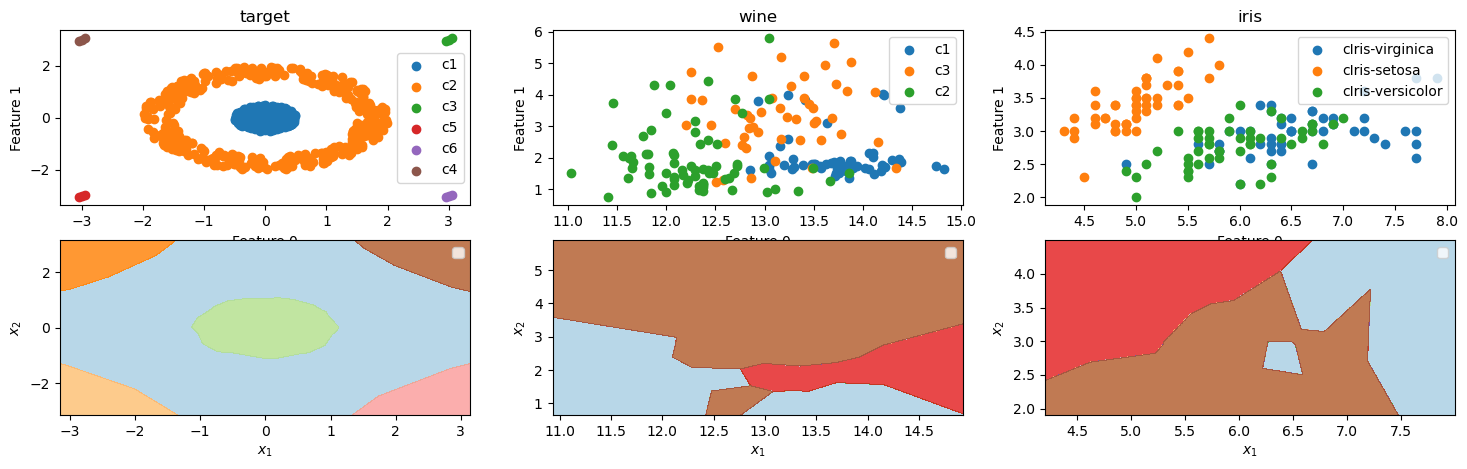

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(18,5))

for i, name in enumerate(data.keys()):
    print(f"XCOBRAS on the dataset: {name}")
    X = data[name].drop(["class"], axis=1).values
    y = data[name]["class"].values

    budget = np.max([60, X.shape[0]//5]
                    )
    xcobras_kmeans = XCOBRAS_kmeans(budget)
    _ = xcobras_kmeans.fit(X[:, :2], LabelQuerier(y))
    # axs[0]: ground truth clustering
    plot_2D(X[:, :2], y, axs[0][i], pca_t = False, title=name)

    # axs[1]: XCOBRAS_kmeans clustering
    plot_boundary(xcobras_kmeans, X[:, :2], axs[1][i])

    print(f"------")

### ii. First two PC (using PCA)

XCOBRAS on the dataset: target


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


------
XCOBRAS on the dataset: wine


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


------
XCOBRAS on the dataset: iris


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


------


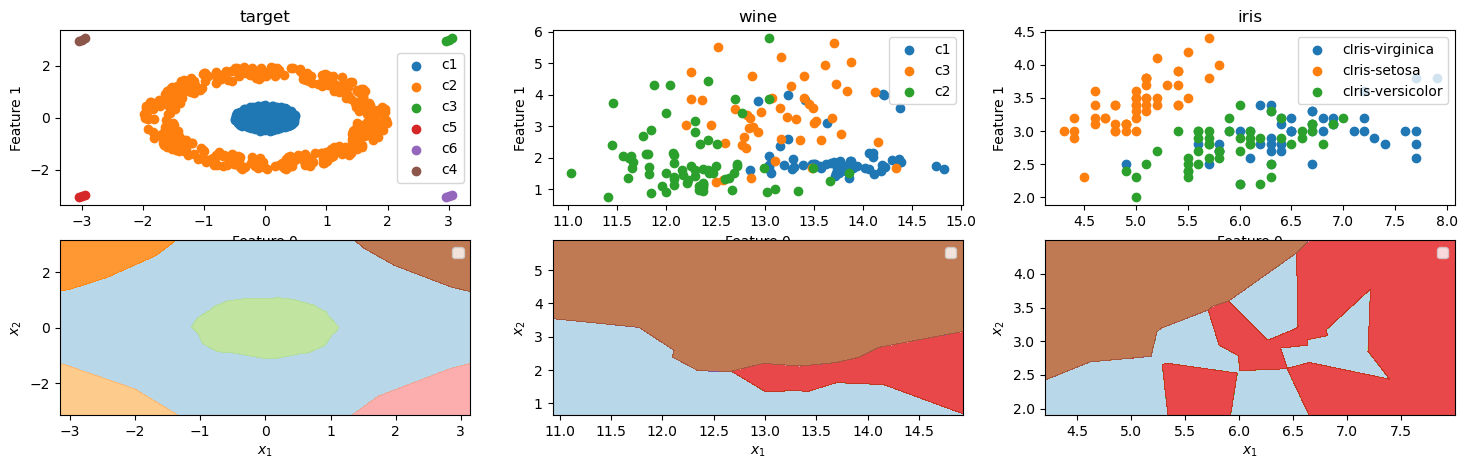

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(18,5))

for i, name in enumerate(data.keys()):
    print(f"XCOBRAS on the dataset: {name}")
    X = data[name].drop(["class"], axis=1).values
    y = data[name]["class"].values

    budget = np.max([60, X.shape[0]//5])
    
    xcobras_kmeans = XCOBRAS_kmeans(budget)
    _ = xcobras_kmeans.fit(X[:, :2], LabelQuerier(y))
    # axs[0]: ground truth clustering
    plot_2D(X[:, :2], y, axs[0][i], title=name)

    # axs[1]: XCOBRAS_kmeans clustering
    plot_boundary(xcobras_kmeans, X[:, :2], axs[1][i])

    print(f"------")

## III. Feature Impotance - (inspired from the EXPLAIN-IT framework)

### 0. COBRAS - Example on the "**wine**" dataset

In [163]:
X = data["wine"].drop(["class"], axis=1)
y = data["wine"]["class"]
feature_names = list(X.columns)

budget = 160

xcobras_kmeans = XCOBRAS_kmeans(budget)
xcobras_kmeans.fit(X.values, LabelQuerier(y.values))
y_hat = xcobras_kmeans.predict(X.values)

In [164]:
set(y_hat)

{0, 1, 2}

Variables:
*  `X`: dataset (Wine)
*  `y`: ground truth
*  `y_hat`: XCOBRAS_kmeans' prediction

### i. Train a supervised learning model on the output of COBRAS
[Pipeline + GridSearchCV reference](https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html)


Two supervised models will be used:
* Support Vector Machine ([SVC from `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html))
* Multi-Layer Perceptron - p-e ... 

In [165]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import train_test_split, HalvingGridSearchCV, GridSearchCV
from sklearn.svm import SVC
# import 2e modèle

# ----- dataset split (X and y_hat)
X_train, X_test, y_hat_train, y_hat_test = train_test_split(
        X, y_hat, test_size=0.4, random_state=42
    )

In [166]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42)
model.fit(X_train.values, y_hat_train)
score = model.score(X_test.values, y_hat_test)
score # le score nul est voulu

0.7916666666666666

Cross-validation are used while computing the "f1-score" ?

In [167]:
# ----- Cross-Validation on the TRAIN set
# ----- Model training
# RBF Model
rbf_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
])

In [168]:
# ----- HalvingGridSearch on the TEST set
# ----- Hyperparameters fine tuning

# To make the cross validation
gammas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
Cs = [1, 10, 100, 1e3, 1e4, 1e5]
param_grid = {
    "svm_clf__gamma": gammas, 
    "svm_clf__C": Cs
    }

# HalvingGridSearchCV
grid_search_halving = GridSearchCV(
    estimator=rbf_kernel_svm_clf, 
    param_grid=param_grid, 
    # factor=2, # only half of the candidates are selected
    cv=2 # default value
    )

# Fitting this model
grid_search_halving.fit(X_train.values,y_hat_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm_clf', SVC(C=0.001, gamma=5))]),
             param_grid={'svm_clf__C': [1, 10, 100, 1000.0, 10000.0, 100000.0],
                         'svm_clf__gamma': [0.1, 0.01, 0.001, 0.0001, 1e-05,
                                            1e-06, 1e-07]})

In [169]:
# pd.DataFrame(grid_search_halving.cv_results_).head(3)
grid_search_halving.best_params_

{'svm_clf__C': 1, 'svm_clf__gamma': 0.1}

> Showing the f1-score `'macro'`*:
>   *  ``'macro'``: Calculate metrics for each label, and find their unweighted mean.  This does not take label imbalance into account.

In [170]:
best_svm_clf = grid_search_halving.best_estimator_
y_test_pred = best_svm_clf.predict(X_test.values)

print(f"f1-score (macro): {f1_score(y_hat_test, y_test_pred, average='macro')}")
print(f"         (micro): {f1_score(y_hat_test, y_test_pred, average='micro')}")
print(f"accuracy_score:   {accuracy_score(y_hat_test, y_test_pred)}")

f1-score (macro): 0.8850408850408851
         (micro): 0.8888888888888888
accuracy_score:   0.8888888888888888


### ii. SHAP
#### Apply on both `XCOBRAS_kmeans` and `RBF SVM` models
> **Note:** We are giving the whole dataset to XCOBRAS_kmeans, but only the training

**General idea:**  
1. Get all the instances of a certain cluster
2. Explain the whole cluster
3. Show explanation of 2 samples

In [185]:
label = np.random.choice(list(set(y_hat)))
print(f"Chosen label: {label}")
X_label = X[list(y_hat)==label]
print(f"Number of instances: {X_label.shape[0]}")
# instance0, instance1 = X_label[0].values, X_label[1].values
# X_label

#  ---- COBRAS
explainer_XCOBRAS_kmeans = shap.Explainer(
    xcobras_kmeans.predict,
    X_label.values,
    feature_names=list(X.columns)
)
print("XCOBRAS explainer .... ")
XCOBRAS_shap_values = explainer_XCOBRAS_kmeans(X_label.values)


#  ---- SVM
explainer_SVM_clf = shap.Explainer(
    best_svm_clf.predict,
    X_label.values,
    feature_names=list(X.columns)
)
print("SVM_clf explainer .... ")
SVM_clf_shap_values = explainer_SVM_clf(X_label)

#  ---- LogisticRegression
explainer_log_reg = shap.Explainer(
    model.predict,
    X_label.values,
    feature_names=list(X.columns)
)
print("log_reg explainer .... ")
log_reg_shap_values = explainer_log_reg(X_label)


Chosen label: 2
Number of instances: 46
XCOBRAS explainer .... 


Permutation explainer: 47it [02:14,  3.12s/it]                        


SVM_clf explainer .... 
log_reg explainer .... 


In [184]:
X_label

,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280/OD315_of_diluted_wines,Proline
59,12.37,0.94,1.36,10.6,88.0,1.98,0.57,0.28,0.42,1.95,1.05,1.82,520.0
61,12.64,1.36,2.02,16.8,100.0,2.02,1.41,0.53,0.62,5.75,0.98,1.59,450.0
62,13.67,1.25,1.92,18.0,94.0,2.10,1.79,0.32,0.73,3.80,1.23,2.46,630.0
63,12.37,1.13,2.16,19.0,87.0,3.50,3.10,0.19,1.87,4.45,1.22,2.87,420.0
64,12.17,1.45,2.53,19.0,104.0,1.89,1.75,0.45,1.03,2.95,1.45,2.23,355.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,12.04,4.30,2.38,22.0,80.0,2.10,1.75,0.42,1.35,2.60,0.79,2.57,580.0
138,13.49,3.59,2.19,19.5,88.0,1.62,0.48,0.58,0.88,5.70,0.81,1.82,580.0
142,13.52,3.17,2.72,23.5,97.0,1.55,0.52,0.50,0.55,4.35,0.89,2.06,520.0
146,13.88,5.04,2.23,20.0,80.0,0.98,0.34,0.40,0.68,4.90,0.58,1.33,415.0


In [173]:
# If we look at the two first explanations
# shap.plots.waterfall(XCOBRAS_shap_values[0])
# plt.text(0.5, 0.5, 'Some text', transform=plt.transAxes)

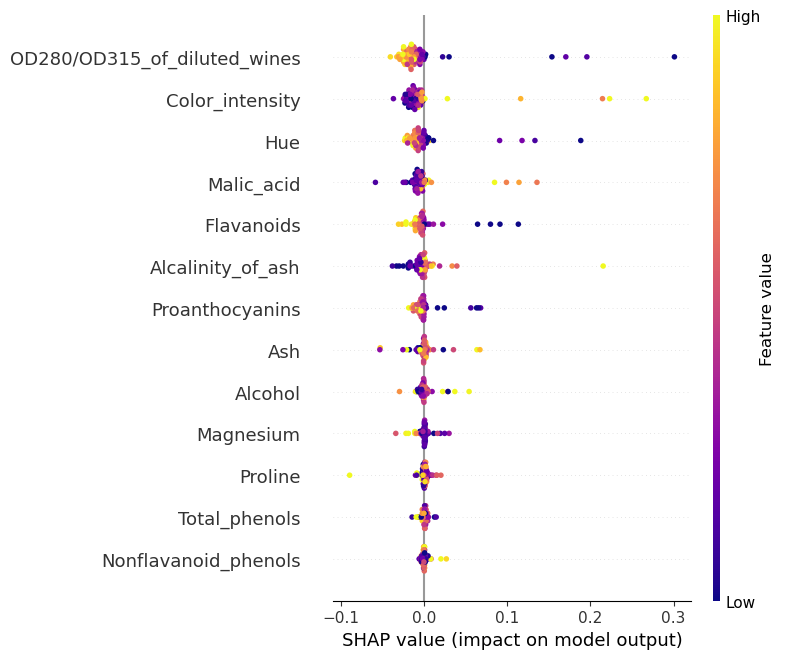

In [174]:
shap.summary_plot(SVM_clf_shap_values, 
                  X_label.values,
                  cmap = "plasma")

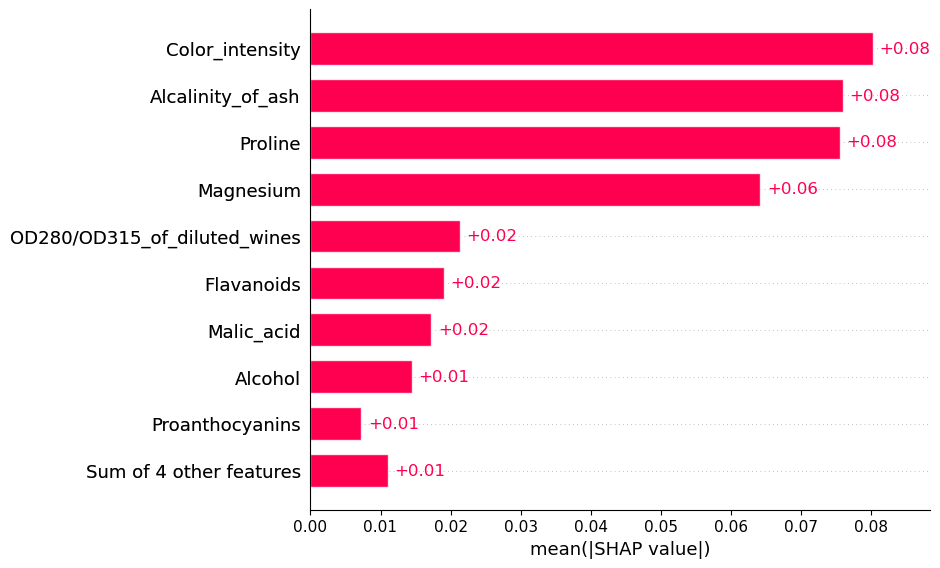

In [175]:
shap.plots.bar(log_reg_shap_values)

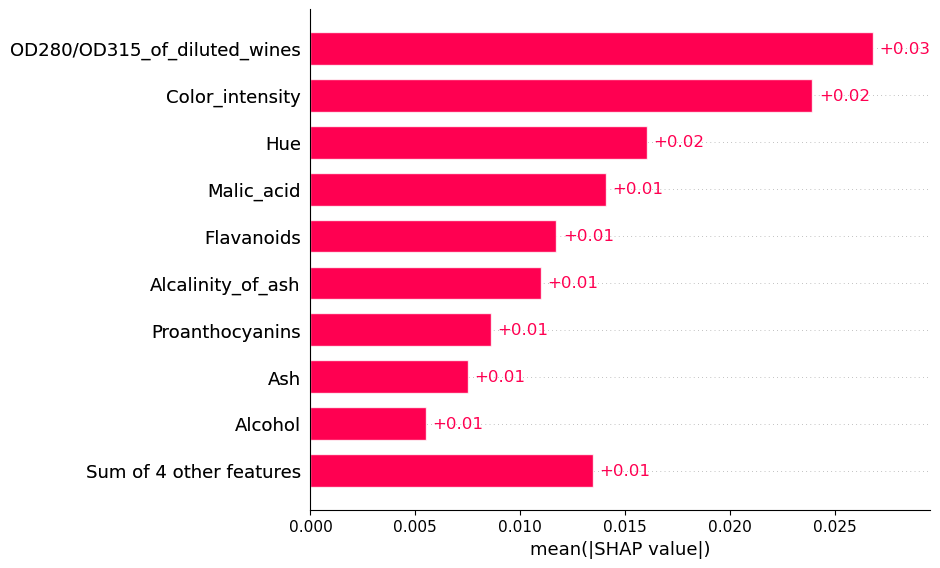

In [176]:
shap.plots.bar(SVM_clf_shap_values)

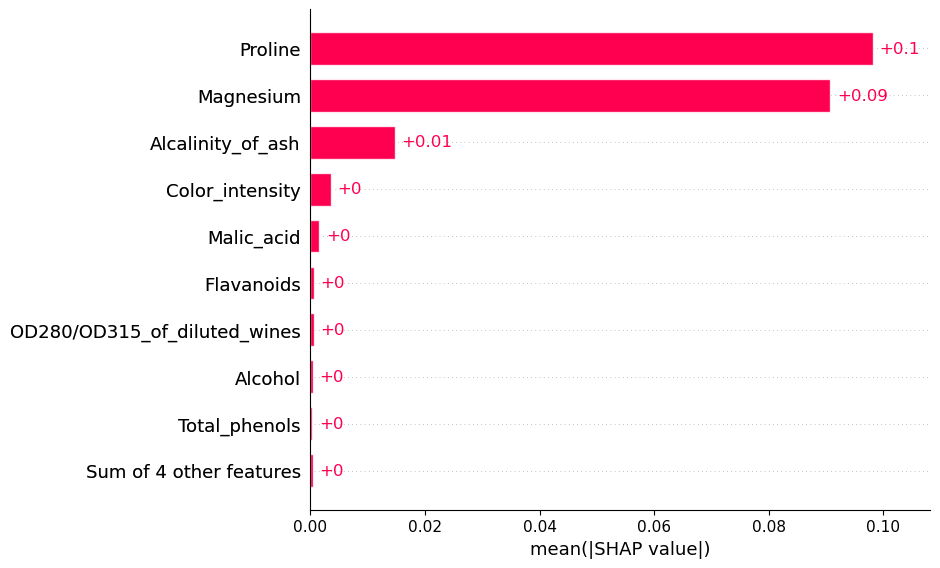

In [177]:
shap.plots.bar(XCOBRAS_shap_values)

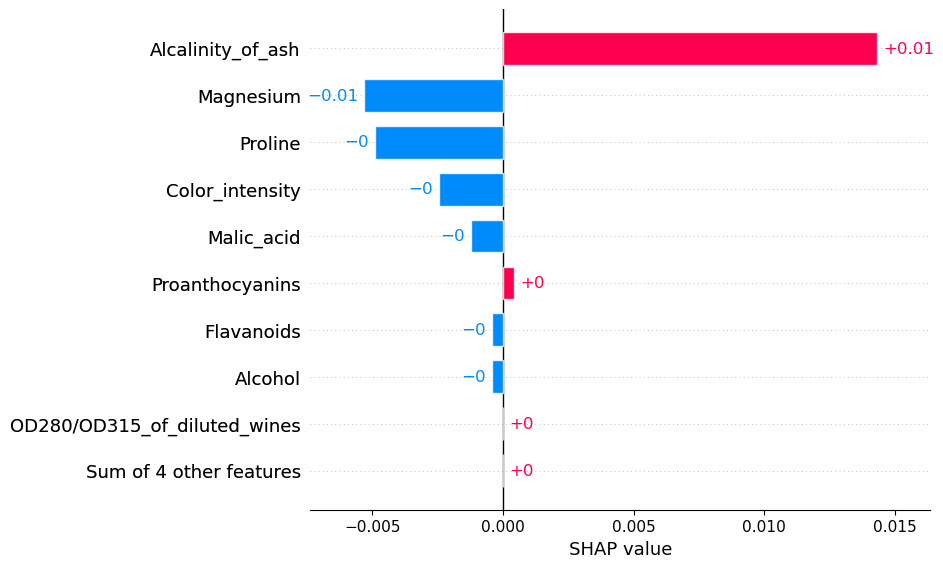

In [183]:
shap.plots.bar(XCOBRAS_shap_values[19])

In [83]:



#  ---- COBRAS


#  ---- SVM

Chosen label: 5


DimensionError: The passed data does not match the background shape expected by the masker! The data of shape (2,) was passed while the masker expected data of shape (13,).

### iii. LIME

In [186]:
set(y)

{'1', '2', '3'}